In [1]:
from pathlib import Path
from columbo.toxicity import WikipediaToxicCommentsWithEmbeddingsDataset, get_datasets_with_embedding
import matplotlib.pyplot as plt
%matplotlib inline
import wandb
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from dotenv import load_dotenv
from codetiming import Timer
from tqdm.notebook import tqdm

load_dotenv()

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
# device = torch.device("cpu")

train_ds, val_ds, test_ds = get_datasets_with_embedding(device)

train_dataloader = DataLoader(
    train_ds, 
    batch_size=32, 
    shuffle=True,
    num_workers=0,
)

In [7]:
class ToxicityClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ToxicityClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x):
        x = self.model(x)
        x = torch.sigmoid(x)
        return x
    
# model = ToxicityClassifier(input_size=768, hidden_size=256, output_size=2)
# print(model)


In [9]:
next(iter(train_dataloader))["embedding"].shape

torch.Size([32, 768])

In [10]:
batch_size, input_dim = next(iter(train_dataloader))["embedding"].shape
model = ToxicityClassifier(input_size=input_dim, hidden_size=256, output_size=2).to(device)
print(model)

ToxicityClassifier(
  (model): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=2, bias=True)
  )
)


In [4]:
# item = train_ds.__getitem__(idx)
# batch_dict, label = item["tokens"], item["label"]
# outputs = embed(**batch_dict)
# embeddings = outputs.last_hidden_state[:, 0]
# embeddings = F.normalize(embeddings, p=2, dim=1)

In [14]:
sample = next(iter(train_dataloader))
X, y = sample["embedding"], sample["label"]
y_pred = model(X)

In [18]:
loss_fn = nn.CrossEntropyLoss()
y_oh = torch.nn.functional.one_hot(y, num_classes=2).float()
loss = loss_fn(y_pred.squeeze(), y_oh)

In [19]:
loss

tensor(0.6934, device='mps:0', grad_fn=<DivBackward1>)

In [17]:
y_pred.device

device(type='mps', index=0)

## Training the Classifier

In [26]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 10
losses = []
epoch_timer = Timer(name="epoch_timer", logger=None)
batch_timer = Timer(name="batch_timer", logger=None)

wandb.init(
    # set the wandb project where this run will be logged
    project="toxicity-classifier",
    # track hyperparameters and run metadata
    config={
    "learning_rate": learning_rate,
    "architecture": "MLP",
    "dataset": train_ds.__class__,
    "epochs": epochs,
    }
)

In [ ]:
for epoch in range(epochs):
    epoch_timer.start()
    model.train()
    print(f"---- Starting epoch {epoch} [last={epoch_timer.last:.2f} s] ----")
    for idx, sample in enumerate(train_dataloader):
        batch_timer.start()
        X, y = sample["embedding"], sample["label"]
        optimizer.zero_grad()
        y_pred = model(X)
        y_oh = torch.nn.functional.one_hot(y, num_classes=2).float()
        loss = loss_fn(y_pred.squeeze(), y_oh)
        loss.backward()
        optimizer.step()
        loss_np = loss.cpu().detach().numpy()
        losses.append(loss_np)
        wandb.log({"loss": loss_np})
        batch_timer.stop()
        if idx % 50 == 0:
            print(f"Loss = {loss_np}")
    epoch_timer.stop()
    
wandb.finish()

---- Starting epoch 0 [last=nan s] ----
Loss = 0.42122790217399597
Loss = 0.3269304037094116
Loss = 0.39996498823165894
Loss = 0.38389503955841064
Loss = 0.32948923110961914
Loss = 0.3694954216480255
Loss = 0.4411345422267914
Loss = 0.31342726945877075
Loss = 0.34706956148147583
Loss = 0.3366428017616272
Loss = 0.44847673177719116
Loss = 0.36627909541130066
Loss = 0.4072345793247223
Loss = 0.35052818059921265
Loss = 0.375754177570343
Loss = 0.36134767532348633
Loss = 0.31921151280403137
---- Starting epoch 1 [last=18.61 s] ----
Loss = 0.32920247316360474
Loss = 0.3631014823913574
Loss = 0.4090377688407898
Loss = 0.36372166872024536
Loss = 0.37559154629707336
Loss = 0.3893590569496155
Loss = 0.4092671871185303
Loss = 0.3218860626220703
Loss = 0.358441561460495
Loss = 0.4004371762275696
Loss = 0.3792690336704254
Loss = 0.5095125436782837
Loss = 0.4322882890701294
Loss = 0.34528428316116333
Loss = 0.42073261737823486
Loss = 0.4080372452735901
Loss = 0.4272734522819519
---- Starting epoch 

In [37]:
loss

tensor(0.3133, grad_fn=<DivBackward1>)

In [38]:
torch.save({
    'epoch': 2,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    }, 
    "toxicity_classifier.pth"
)

In [41]:
import numpy as np

In [42]:
np.array(losses)

array([0.69253296, 0.6749906 , 0.6554836 , ..., 0.44754562, 0.3811513 ,
       0.3133482 ], dtype=float32)

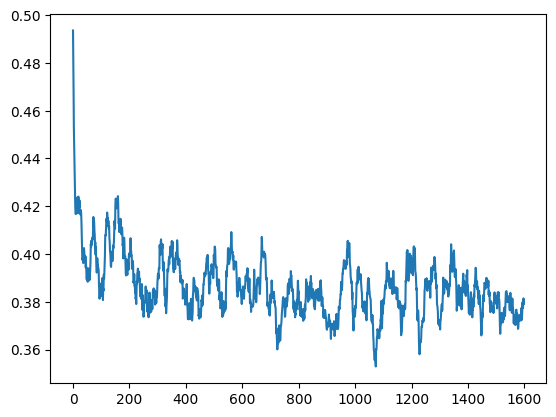

In [48]:
window_size = 20
weights = np.ones(window_size) / window_size
losses_sma = np.convolve(losses, weights, mode='valid')

plt.plot(losses_sma)

In [3]:


# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset

    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
wandb: Currently logged in as: blackplane (blackplane34). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadl

acc,▁▆▄▇▆▇█▆
loss,█▄▂▂▁▂▂▁
acc,0.73252
loss,0.18606


In [6]:
import torch.nn as nn
m = nn.Dropout(p=0.5)
input = torch.randn(20, 16)
output = m(input)

In [7]:
output

tensor([[-2.8997e-01, -0.0000e+00, -0.0000e+00, -0.0000e+00,  2.4487e+00,
          1.2077e+00, -0.0000e+00, -4.0735e+00, -2.3964e+00, -0.0000e+00,
         -0.0000e+00,  0.0000e+00,  1.8235e+00, -1.0931e+00,  1.7487e+00,
         -0.0000e+00],
        [-0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00,  3.1338e+00,  0.0000e+00, -2.2775e-03,  1.6744e+00,
         -1.4507e+00,  9.1966e-01, -2.4533e+00,  0.0000e+00, -7.9773e-01,
         -1.1351e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00,  2.0157e+00, -2.7741e+00,
         -2.0289e+00,  1.0746e+00, -3.2261e+00,  0.0000e+00, -0.0000e+00,
          3.2361e+00, -2.1248e+00,  8.5811e-01, -2.0835e+00, -1.5369e+00,
          0.0000e+00],
        [-0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00,
          0.0000e+00,  0.0000e+00,  8.0641e-01,  1.5341e+00,  1.0178e-01,
          2.3954e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00,
         -0.0000e+00],
        [ 1.1729e+00

In [2]:
path: Path = Path.home() / "Data" / "Wikipedia-Toxic-Comments"
train_ds = WikipediaToxicCommentsDataset(path / "balanced_train.csv")

In [10]:
import pandas as pd
import tqdm as tqdm
from utils.toxicity import embed, build_embedding

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

tokenizer, embedder = build_embedding(device=device)
dataset_dir = Path.home() / "Data" / "Wikipedia-Toxic-Comments" 
df = pd.read_csv(dataset_dir / "balanced_train.csv")
embeddings = [embed(text, tokenizer, embedder) for text in tqdm(df["comment_text"].values[0:3])]
embeddings = [e.cpu().detach().numpy() for e in embeddings]
df["embeddings"] = embeddings

df.to_csv(dataset_dir / "balanced_train_with_embeddings.csv")

  0%|          | 0/3 [00:00<?, ?it/s]

array([[-1.00936126e-02, -2.74826363e-02, -4.37324271e-02,
        -3.21844742e-02, -5.19072963e-03, -2.58033872e-02,
         1.22725200e-02,  1.01181604e-02,  2.45542005e-02,
         1.16217858e-03, -2.32939776e-02, -1.14419935e-02,
        -6.49814447e-03, -1.64673347e-02, -1.85538214e-02,
        -7.38415460e-04, -1.25559345e-02, -2.35037953e-02,
         2.91832108e-02, -3.31682190e-02, -1.29818451e-02,
         2.01689731e-02, -3.22065093e-02, -6.46326970e-03,
         1.82331577e-02, -7.11647272e-02, -1.89235713e-02,
        -1.73050296e-02, -1.68382805e-02, -5.12989238e-02,
         4.51433510e-02, -2.06822772e-02, -1.87631119e-02,
        -1.00885760e-02,  6.85930112e-03, -7.60592660e-03,
        -3.58960293e-02,  6.59328550e-02,  1.96182281e-02,
         1.63608547e-02, -1.60855446e-02, -4.47126962e-02,
         2.10482664e-02, -7.54378410e-03, -1.37416893e-04,
         1.83338039e-02, -9.93031776e-04, -1.22056771e-02,
         3.79942432e-02, -5.65163419e-02,  8.49633827e-0